# Data Processing

In this notebook the following tasks will be done:
- Inspect the data and handle inconsistancies and missing values
- Stablish the questions we want to answer with the data

In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
raw_df: pl.DataFrame = pl.read_csv(
    "../data/raw/world-data-2023.csv", ignore_errors=True
)

# Fix some column names
raw_df = raw_df.rename({"Density\r\n(P/Km2)": "Density(P/Km2)"})
raw_df = raw_df.rename({"Agricultural Land( %)": "Agricultural Land(%)"})
raw_df = raw_df.rename({"Urban_population": "Urban population"})

raw_df.head(5)

Country,Density(P/Km2),Abbreviation,Agricultural Land(%),Land Area(Km2),Armed Forces size,Birth Rate,Calling Code,Capital/Major City,Co2-Emissions,CPI,CPI Change (%),Currency-Code,Fertility Rate,Forested Area (%),Gasoline Price,GDP,Gross primary education enrollment (%),Gross tertiary education enrollment (%),Infant mortality,Largest city,Life expectancy,Maternal mortality ratio,Minimum wage,Official language,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban population,Latitude,Longitude
str,str,str,str,str,str,f64,i64,str,str,f64,str,str,f64,str,str,str,str,str,f64,str,f64,i64,str,str,str,f64,str,str,str,str,str,str,f64,f64
"""Afghanistan""","""60""","""AF""","""58.10%""","""652,230""","""323,000""",32.49,93,"""Kabul""","""8,672""",149.9,"""2.30%""","""AFN""",4.47,"""2.10%""","""$0.70 ""","""$19,101,353,833 ""","""104.00%""","""9.70%""",47.9,"""Kabul""",64.5,638,"""$0.43 ""","""Pashto""","""78.40%""",0.28,"""38,041,754""","""48.90%""","""9.30%""","""71.40%""","""11.12%""","""9,797,273""",33.93911,67.709953
"""Albania""","""105""","""AL""","""43.10%""","""28,748""","""9,000""",11.78,355,"""Tirana""","""4,536""",119.05,"""1.40%""","""ALL""",1.62,"""28.10%""","""$1.36 ""","""$15,278,077,447 ""","""107.00%""","""55.00%""",7.8,"""Tirana""",78.5,15,"""$1.12 ""","""Albanian""","""56.90%""",1.2,"""2,854,191""","""55.70%""","""18.60%""","""36.60%""","""12.33%""","""1,747,593""",41.153332,20.168331
"""Algeria""","""18""","""DZ""","""17.40%""","""2,381,741""","""317,000""",24.28,213,"""Algiers""","""150,006""",151.36,"""2.00%""","""DZD""",3.02,"""0.80%""","""$0.28 ""","""$169,988,236,398 ""","""109.90%""","""51.40%""",20.1,"""Algiers""",76.7,112,"""$0.95 ""","""Arabic""","""28.10%""",1.72,"""43,053,054""","""41.20%""","""37.20%""","""66.10%""","""11.70%""","""31,510,100""",28.033886,1.659626
"""Andorra""","""164""","""AD""","""40.00%""","""468""",null,7.2,376,"""Andorra la Vella""","""469""",null,null,"""EUR""",1.27,"""34.00%""","""$1.51 ""","""$3,154,057,987 ""","""106.40%""",null,2.7,"""Andorra la Vella""",null,null,"""$6.63 ""","""Catalan""","""36.40%""",3.33,"""77,142""",null,null,null,null,"""67,873""",42.506285,1.521801
"""Angola""","""26""","""AO""","""47.50%""","""1,246,700""","""117,000""",40.73,244,"""Luanda""","""34,693""",261.73,"""17.10%""","""AOA""",5.52,"""46.30%""","""$0.97 ""","""$94,635,415,870 ""","""113.50%""","""9.30%""",51.6,"""Luanda""",60.8,241,"""$0.71 ""","""Portuguese""","""33.40%""",0.21,"""31,825,295""","""77.50%""","""9.20%""","""49.10%""","""6.89%""","""21,061,025""",-11.202692,17.873887


In [3]:
pl.DataFrame(dict(zip(raw_df.columns, raw_df.dtypes)))

Country,Density(P/Km2),Abbreviation,Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Calling Code,Capital/Major City,Co2-Emissions,CPI,CPI Change (%),Currency-Code,Fertility Rate,Forested Area (%),Gasoline Price,GDP,Gross primary education enrollment (%),Gross tertiary education enrollment (%),Infant mortality,Largest city,Life expectancy,Maternal mortality ratio,Minimum wage,Official language,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban_population,Latitude,Longitude
object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
String,String,String,String,String,String,Float64,Int64,String,String,Float64,String,String,Float64,String,String,String,String,String,Float64,String,Float64,Int64,String,String,String,Float64,String,String,String,String,String,String,Float64,Float64


## Type conversion

We observed that some of the columns are not in the correct data type. We will convert them to the correct data type.

Certain columns contain numerical values formatted as strings with commas (`,`) as thousand separators. These need to be cleaned and converted into integers. These columns include:
- `Density(P/Km2)`
- `Land Area(Km2)`
- `Armed Forces size`
- `Co2-Emissions`
- `Population`
- `Urban population`

Some columns contain monetary values formatted as strings with dollar signs (`$`) and commas (`,`) as thousand separators. These need to be cleaned and converted into floats. These columns include:
- `Gasoline Price`
- `GDP`
- `Minimum wage`

Some columns contain percentages formatted as strings with percentage signs (`%`). These need to be cleaned and converted into floats. These columns include:
- `Agricultural Land(%)`
- `CPI Change (%)`
- `Forested Area (%)`
- `Gross primary education enrollment (%)`
- `Gross tertiary education enrollment (%)`
- `Out of pocket health expenditure`
- `Population: Labor force participation (%)`
- `Tax revenue (%)`
- `Total tax rate`
- `Unemployment rate`

In [12]:
data = raw_df.clone()

# Columns that should be integers
int_columns = [
    "Density(P/Km2)",
    "Land Area(Km2)",
    "Armed Forces size",
    "Co2-Emissions",
    "Population",
    "Urban population",
]
data = data.with_columns(
    [
        pl.col(col).str.strip_chars().str.replace_all(",", "").cast(pl.Int64)
        for col in int_columns
    ]
)

# Currency columns that should be floats
float_columns_currency = ["Gasoline Price", "GDP", "Minimum wage"]
data = data.with_columns(
    [
        pl.col(col).str.strip_chars().str.replace_all(r"[\$,]", "").cast(pl.Float64)
        for col in float_columns_currency
    ]
)

# Percentage columns that should be floats
float_columns_percentage = [
    "Agricultural Land(%)",
    "CPI Change (%)",
    "Forested Area (%)",
    "Gross primary education enrollment (%)",
    "Gross tertiary education enrollment (%)",
    "Out of pocket health expenditure",
    "Population: Labor force participation (%)",
    "Tax revenue (%)",
    "Total tax rate",
    "Unemployment rate",
]
data = data.with_columns(
    [
        pl.col(col).str.strip_chars().str.replace_all("%", "").cast(pl.Float64)
        for col in float_columns_percentage
    ]
)

data.head(10)

Country,Density(P/Km2),Abbreviation,Agricultural Land(%),Land Area(Km2),Armed Forces size,Birth Rate,Calling Code,Capital/Major City,Co2-Emissions,CPI,CPI Change (%),Currency-Code,Fertility Rate,Forested Area (%),Gasoline Price,GDP,Gross primary education enrollment (%),Gross tertiary education enrollment (%),Infant mortality,Largest city,Life expectancy,Maternal mortality ratio,Minimum wage,Official language,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban population,Latitude,Longitude
str,i64,str,f64,i64,i64,f64,i64,str,i64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,str,f64,i64,f64,str,f64,f64,i64,f64,f64,f64,f64,i64,f64,f64
"""Afghanistan""",60,"""AF""",58.1,652230,323000,32.49,93,"""Kabul""",8672,149.9,2.3,"""AFN""",4.47,2.1,0.7,1.9101e10,104.0,9.7,47.9,"""Kabul""",64.5,638,0.43,"""Pashto""",78.4,0.28,38041754,48.9,9.3,71.4,11.12,9797273,33.93911,67.709953
"""Albania""",105,"""AL""",43.1,28748,9000,11.78,355,"""Tirana""",4536,119.05,1.4,"""ALL""",1.62,28.1,1.36,1.5278e10,107.0,55.0,7.8,"""Tirana""",78.5,15,1.12,"""Albanian""",56.9,1.2,2854191,55.7,18.6,36.6,12.33,1747593,41.153332,20.168331
"""Algeria""",18,"""DZ""",17.4,2381741,317000,24.28,213,"""Algiers""",150006,151.36,2.0,"""DZD""",3.02,0.8,0.28,1.6999e11,109.9,51.4,20.1,"""Algiers""",76.7,112,0.95,"""Arabic""",28.1,1.72,43053054,41.2,37.2,66.1,11.7,31510100,28.033886,1.659626
"""Andorra""",164,"""AD""",40.0,468,null,7.2,376,"""Andorra la Vella""",469,null,null,"""EUR""",1.27,34.0,1.51,3.1541e9,106.4,null,2.7,"""Andorra la Vella""",null,null,6.63,"""Catalan""",36.4,3.33,77142,null,null,null,null,67873,42.506285,1.521801
"""Angola""",26,"""AO""",47.5,1246700,117000,40.73,244,"""Luanda""",34693,261.73,17.1,"""AOA""",5.52,46.3,0.97,9.4635e10,113.5,9.3,51.6,"""Luanda""",60.8,241,0.71,"""Portuguese""",33.4,0.21,31825295,77.5,9.2,49.1,6.89,21061025,-11.202692,17.873887
"""Antigua and Barbuda""",223,"""AG""",20.5,443,0,15.33,1,"""St. John's, Saint John""",557,113.81,1.2,"""XCD""",1.99,22.3,0.99,1.7278e9,105.0,24.8,5.0,"""St. John's, Saint John""",76.9,42,3.04,"""English""",24.3,2.76,97118,null,16.5,43.0,null,23800,17.060816,-61.796428
"""Argentina""",17,"""AR""",54.3,2780400,105000,17.02,54,"""Buenos Aires""",201348,232.75,53.5,"""ARS""",2.26,9.8,1.1,4.4966e11,109.7,90.0,8.8,"""Buenos Aires""",76.5,39,3.35,"""Spanish""",17.6,3.96,44938712,61.3,10.1,106.3,9.79,41339571,-38.416097,-63.616672
"""Armenia""",104,"""AM""",58.9,29743,49000,13.99,374,"""Yerevan""",5156,129.18,1.4,"""AMD""",1.76,11.7,0.77,1.3673e10,92.7,54.6,11.0,"""Yerevan""",74.9,26,0.66,"""Armenian""",81.6,4.4,2957731,55.6,20.9,22.6,16.99,1869848,40.069099,45.038189
"""Australia""",3,"""AU""",48.2,7741220,58000,12.6,61,"""Canberra""",375908,119.8,1.6,"""AUD""",1.74,16.3,0.93,1.3927e12,100.3,113.1,3.1,"""Sydney""",82.7,6,13.59,"""None""",19.6,3.68,25766605,65.5,23.0,47.4,5.27,21844756,-25.274398,133.775136


Now, we are going to display the percentage of missing values in each column.

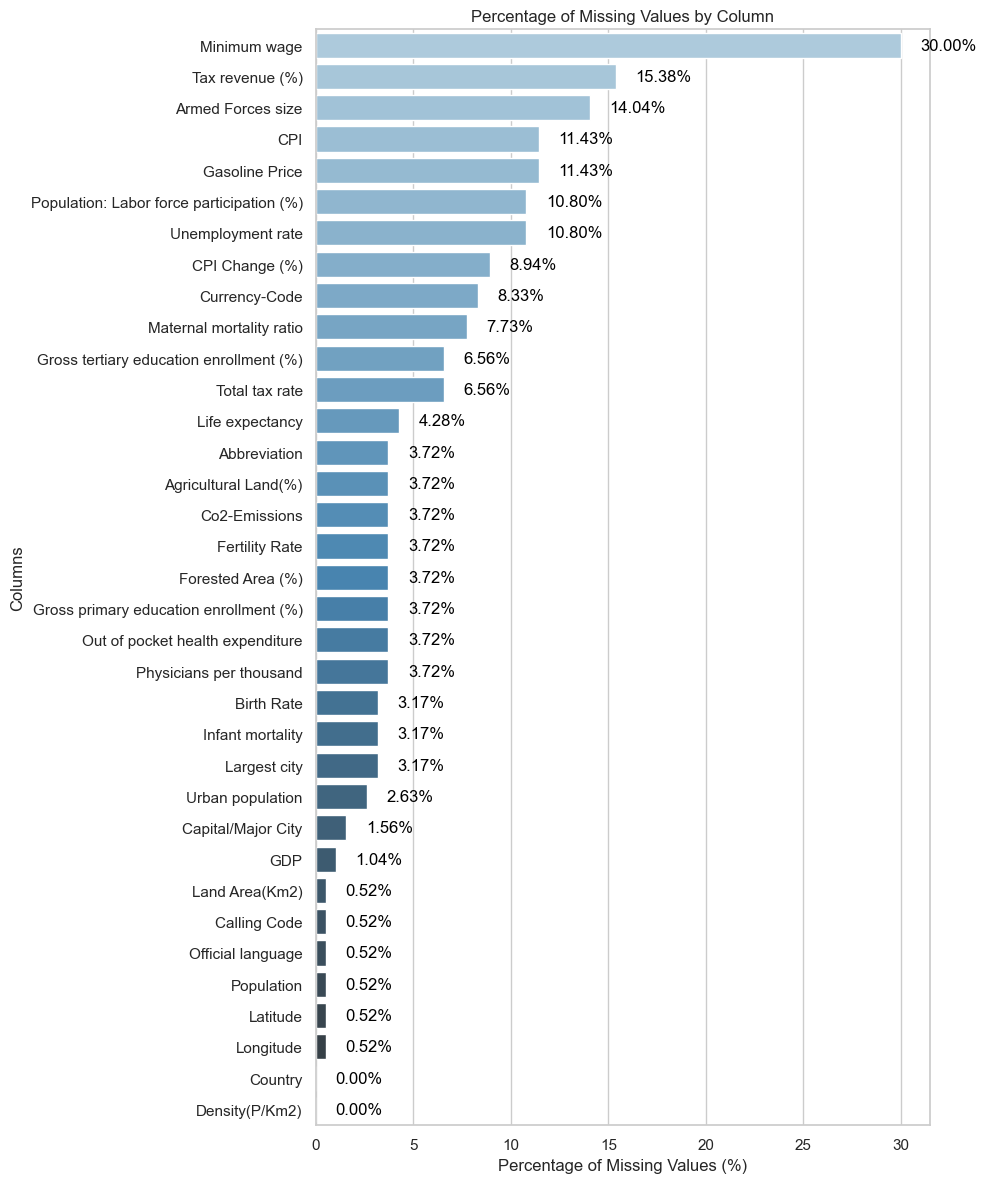

In [13]:
missing_data_summary = (
    data.select(
        [
            ((pl.col(column).is_null().sum() / pl.col(column).count()) * 100).alias(
                column
            )
            for column in data.columns
        ]
    )
    .transpose(include_header=True)
    .sort(by="column_0", descending=True)
)

# with pl.Config(tbl_rows=data.shape[0]):
#     print(missing_data_summary)

columns = missing_data_summary["column"].to_list()
missing_percentages = missing_data_summary["column_0"].to_list()

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 12))
ax = sns.barplot(x=missing_percentages, y=columns, palette="Blues_d", hue=columns)

for p in ax.patches:
    ax.text(
        p.get_width() + 1,
        p.get_y() + p.get_height() / 2,
        f"{p.get_width():.2f}%",
        va="center",
        ha="left",
        color="black",
    )

plt.xlabel("Percentage of Missing Values (%)")
plt.ylabel("Columns")
plt.title("Percentage of Missing Values by Column")
plt.tight_layout()
plt.show()

### Missing values analysis

- **Minimum wage:** Some countries do not have a minimum wage, so we will fill the missing values with 0.
- **Tax revenue %:** Some countries do not disclose their tax revenue, so we will fill try to come up with questions that do not require this information.
- **Armed forces size:** Some countries do not disclose their armed forces size. We may fill this data by using the average civilian to military ratio of similar countries.
- **CPIs:** Once more, some countries do not disclose this information.

Based on what we see so far, we propose to first find some questions that can be answered with the data we have, and then we will decide how to handle the missing values.

### Columns to be dropped

- **Abbreviation:** This column is not necessary for our analysis, but keep it saved for visualization purposes
- **Calling Code, Capital/Major City, Largest City, Official language:** These columns do not add any valuable information
- **Minimum wage currency:** This column being kept would depend on the questions we want to answer antnd the feasability to find and fill the missing data
- **Latitude, Longitude:** These columns are not necessary for our analysis, but keep it saved for visualization purposes
- **CPI change:** This column does not add any valuable information